In [ ]:
## mounting google drive
from google.colab import drive
drive.mount('/content/drive')

In [16]:
## importing libraries

import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import time

In [27]:
## function definitions

def getFiles(train, path):
    images = []
    count = 0
    if(train is True):
      txt = 'train.txt'
    else:
      txt = 'test.txt'

    for folder in os.listdir(path):
      with open(os.path.join(os.path.join(path, folder), txt), 'r') as f:
        for line in f:
          images.append(os.path.join(os.path.join(path, folder),line.strip()))

    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    #plt.xticks(x_scalar, rotation = 45)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
        9: 1,
        10: 1
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def findcluster(im_features, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(im_features)
    return kmeans

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["sign 1", "sign 2", "sign 3", "sign 4", "sign 5", "sign 6", "sign 7", "sign 8", "sign 9", "sign 10"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy: %0.3f' % accuracy_score(true, predictions))
    print ('precision: %0.3f' % precision_score(true, predictions, average = 'weighted'))
    print ('recall: %0.3f' % recall_score(true, predictions, average = 'weighted'))
    print ('f1: %0.3f' % f1_score(true, predictions, average = 'weighted'))


**Dataset Visualization** (one image from each class)

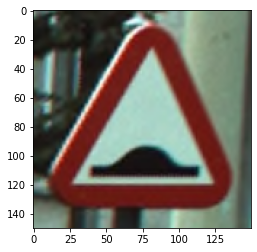

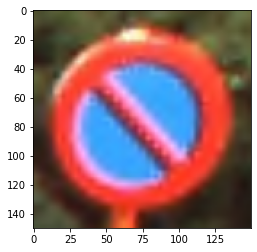

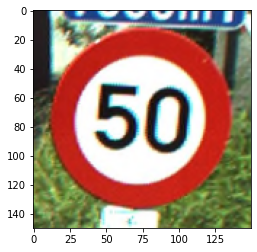

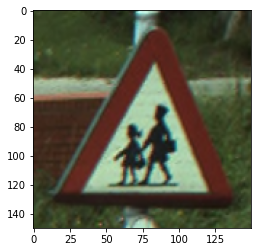

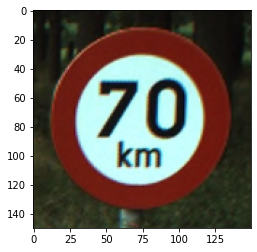

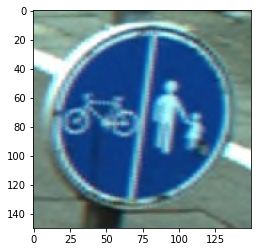

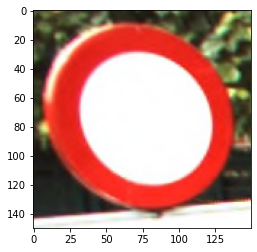

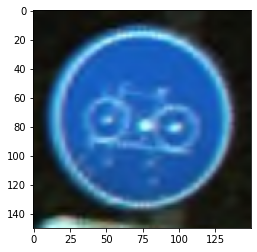

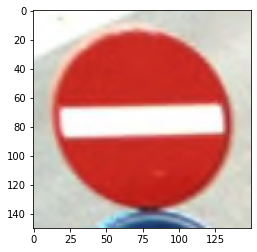

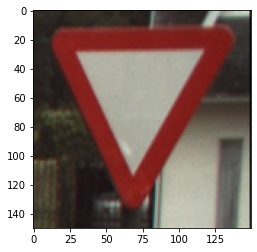

In [6]:
path = '/content/drive/MyDrive/Dataset/CS67_Fall2022_ A1_Dataset'
for folder in os.listdir(path):
        file = os.listdir(os.path.join(path, folder))[0]
        img_path = os.path.join(path, os.path.join(folder, file))
        img = readImage(img_path)
        fig = plt.imshow(img)
        plt.show(fig)

**1.** **Supervised Paradigm using SVM**

In [7]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 10
    image_count = len(images)

    for img_path in images:
        if("00001/" in img_path):
            class_index = 1
        elif("00002/" in img_path):
            class_index = 2
        elif("00003/" in img_path):
            class_index = 3
        elif("00004/" in img_path):
            class_index = 4
        elif("00005/" in img_path):
            class_index = 5
        elif("00006/" in img_path):
          class_index = 6
        elif("00007/" in img_path):
            class_index = 7
        elif("00008/" in img_path):
            class_index = 8
        elif("00009/" in img_path):
          class_index = 9
        else:
          class_index = 10

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

**1.1** **Training**

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


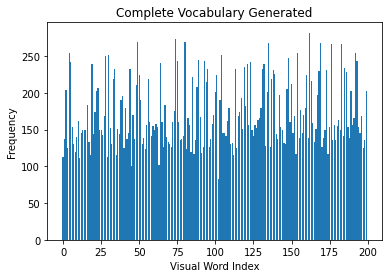

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
--- 283.8737654685974 seconds ---


In [21]:
train_path = "/content/drive/MyDrive/Dataset/CS67_Fall2022_ A1_Dataset"
no_clusters = 200
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "1": "sign 1",
        "2": "sign 2",
        "3": "sign 3",
        "4": "sign 4",
        "5": "sign 5",
        "6": "sign 6",
        "7": "sign 7",
        "8": "sign 8",
        "9": "sign 9",
        "10": "sign 10"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("00001/" in img_path):
                true.append("sign 1")
            elif("00002/" in img_path):
                true.append("sign 2")
            elif("00003/" in img_path):
                true.append("sign 3")
            elif("00004/" in img_path):
                true.append("sign 4")
            elif("00005/" in img_path):
                true.append("sign 5")
            elif("00006/" in img_path):
                true.append("sign 6")
            elif("00007/" in img_path):
                true.append("sign 7")
            elif("00008/" in img_path):
                true.append("sign 8")
            elif("00009/" in img_path):
                true.append("sign 9")
            else:
                true.append("sign 10")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Performance metrics calculated.")
    print("Execution done.")


**1.2** **Testing and Performance Evaluation**

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[18  0  0  0  1  0  0  1  0  0]
 [ 0 19  0  0  0  0  0  0  1  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  1 18  1  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  3  0  0  0 15  0  2  0  0]
 [ 0  0  0  0  0  0 14  6  0  0]
 [ 0  0  0  0  0  1  2 15  1  1]
 [ 0  1  0  0  0  0  0  1 18  0]
 [ 0  0  0  0  0  0  0  0  3 17]]
Normalized confusion matrix
[[0.9  0.   0.   0.   0.05 0.   0.   0.05 0.   0.  ]
 [0.   0.95 0.   0.   0.   0.   0.   0.   0.05 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.9  0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.15 0.   0.   0.   0.75 0.   0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.7  0.3  0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.1  0.75 0.05 0.05]
 [0.   0.05 0.   0.   0.   0.   0.   0.05 0.9  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.15 0.85]]


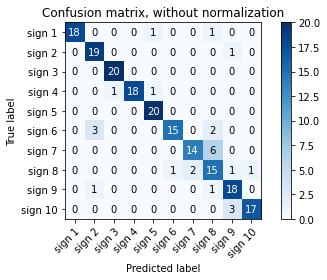

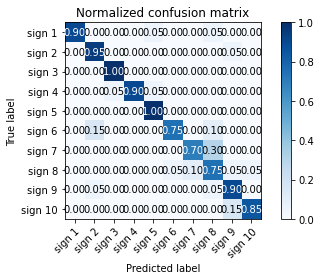

Confusion matrixes plotted.
accuracy: 0.870
precision: 0.883
recall: 0.870
f1: 0.872
Performance metrics calculated.
Execution done.
--- 9.830974578857422 seconds ---


In [28]:
test_path = "/content/drive/MyDrive/Dataset/CS67_Fall2022_ A1_Dataset"
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

We get an accuracy of 87% with current SVM model. Other metrics like recall, precision are also shown. The results look promising.

**2.** **Un-supervised Paradigm using Clustering**

Un-supervised paradigm i.e after feature extraction, we have to use an unsupervised ML model. 
I will use k-means clustering with k = 10 (known distinct classes)

In [57]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    true_labels = np.array([])
    label_count = 10
    image_count = len(images)

    for img_path in images:
        if("00001/" in img_path):
            class_index = 0
        elif("00002/" in img_path):
            class_index = 1
        elif("00003/" in img_path):
            class_index = 2
        elif("00004/" in img_path):
            class_index = 3
        elif("00005/" in img_path):
            class_index = 4
        elif("00006/" in img_path):
          class_index = 5
        elif("00007/" in img_path):
            class_index = 6
        elif("00008/" in img_path):
            class_index = 7
        elif("00009/" in img_path):
          class_index = 8
        else:
          class_index = 9

        true_labels = np.append(true_labels, class_index)      
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    kmeans_cluster = findcluster(im_features, 10)
    print("kmeans classifier fitted.")

    return kmeans, scale, im_features, kmeans_cluster, true_labels

**2.1** **Training**

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


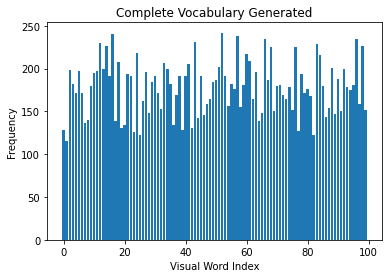

Features histogram plotted.
kmeans classifier fitted.
--- 174.63496375083923 seconds ---


In [58]:
train_path = "/content/drive/MyDrive/Dataset/CS67_Fall2022_ A1_Dataset"
no_clusters = 100
kernel = "precomputed"

start_time = time.time()
kmeans, scale, im_features, kmeans_cluster, true_labels = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

**2.2** **Cluster Visualization**

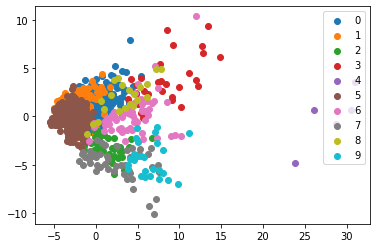

In [54]:
np.shape(im_features)
np.shape(kmeans_cluster.labels_)

from sklearn.decomposition import PCA
 
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(im_features)

label = kmeans_cluster.labels_
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

**2.3** **Performance evaluation**

In [68]:
## for evalution of clustering model, I used rand score

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

print ('rand score: %0.3f' % adjusted_rand_score(true_labels, label))
print ('calinski_harabasz_score: %0.3f' % calinski_harabasz_score(im_features, label))
print ('silhouette_score: %0.3f' % silhouette_score(im_features, label))


rand score: 0.183
calinski_harabasz_score: 39.292
silhouette_score: 0.063


Indicators show that the model performance is not ideal. Either we should improve the exisitng k-means model or try density based algorithms like DBSCAN.